In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Seqbased_model/RF_1302_models \
/media/concha-eloko/Linux/PPT_clean/ficheros_28032023


***
### Load Data :

In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import random
from collections import Counter, defaultdict
import warnings
import logging
import subprocess
from multiprocessing.pool import ThreadPool
import joblib

# SCikitlearn modules :
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report , roc_auc_score, matthews_corrcoef
from sklearn.metrics import roc_auc_score

# Scipy modules : 
from scipy.stats import fisher_exact
#from skopt import BayesSearchCV
#from skopt.space import Real, Categorical, Integer
from statistics import mean

path_work = "/media/concha-eloko/Linux/PPT_clean"
path_jobs = "/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/RF_1302_models"

> Set the count prophage dico : 

In [4]:
DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df_v2.tsv", sep = "\t" ,  header = 0)

DF_info = DF_info.drop_duplicates(subset = ["Protein_name"])

df_prophages = DF_info.drop_duplicates(subset = ["Phage"], keep = "first")
dico_prophage_info = {row["Phage"] : {"prophage_strain" : row["prophage_id"] , "ancestor" : row["Infected_ancestor"]} for _,row in df_prophages.iterrows()}

def get_filtered_prophages(prophage) :
    combinations = []
    to_exclude = set()
    to_keep = set()
    to_keep.add(prophage)
    df_prophage_group = DF_info[(DF_info["prophage_id"] == dico_prophage_info[prophage]["prophage_strain"]) & (DF_info["Infected_ancestor"] == dico_prophage_info[prophage]["ancestor"])]
    if len(df_prophage_group) == 1 :
        pass
    else :
        depo_set = set(df_prophage_group[df_prophage_group["Phage"] == prophage]["domain_seq"].values)
        for prophage_tmp in df_prophage_group["Phage"].unique().tolist() :
            if prophage_tmp != prophage :
                tmp_depo_set = set(df_prophage_group[df_prophage_group["Phage"] == prophage_tmp]["domain_seq"].values)
                if depo_set == tmp_depo_set :
                    to_exclude.add(prophage_tmp)
                else :
                    if tmp_depo_set not in combinations :
                        to_keep.add(prophage_tmp)
                        combinations.append(tmp_depo_set)
                    else :
                        to_exclude.add(prophage_tmp)
    return df_prophage_group , to_exclude , to_keep

good_prophages = set()
excluded_prophages = set()

for prophage, info_prophage in tqdm(dico_prophage_info.items()) :
    if prophage not in excluded_prophages and prophage not in good_prophages:
        _, excluded_members , kept_members = get_filtered_prophages(prophage)
        good_prophages.update(kept_members)
        excluded_prophages.update(excluded_members)

DF_info_lvl_0_filtered = DF_info[DF_info["Phage"].isin(good_prophages)]
DF_info_lvl_0_final = DF_info_lvl_0_filtered[~DF_info_lvl_0_filtered["KL_type_LCA"].str.contains("\\|")]
DF_info_lvl_0 = DF_info_lvl_0_final.copy()

df_prophages = DF_info_lvl_0.drop_duplicates(subset = ["Phage"])
dico_prophage_count = dict(Counter(df_prophages["KL_type_LCA"]))


100%|█████████████████████████████████████████████████████████████████████████████████████████| 15981/15981 [00:30<00:00, 532.60it/s]


In [4]:
cluster_values = set([file.split("_")[0] for file in os.listdir(path_jobs)])
KLtypes = set([file.split("_RF_")[1].split(".full_data")[0] for file in os.listdir(path_jobs)])

KLtypes_paths = {kltype : [f"{path_jobs}/{file}" for file in os.listdir(path_jobs) if file.split("_RF_")[1].split(".full_data")[0]==kltype]
                for kltype in KLtypes}


***
### Get the best cl value :

> Functions :

In [5]:
def get_mean_MCC(path_data_object):
    try:
        assert os.path.isfile(path_data_object)
        data_object = joblib.load(path_data_object)
        mcc_values = []
        for i in data_object:
            y_test = data_object[i]["test_data"][0].values
            predictions = data_object[i]["test_data"][1]
            mcc = matthews_corrcoef(y_test, predictions)
            mcc_values.append(mcc)
        del data_object 
        mean_mcc = mean(mcc_values)
        return mean_mcc
    except AssertionError:
        raise FileNotFoundError(f"File not found: {path_data_object}")

    

> Get the best model : 

In [26]:
%%time
with open(f"/media/concha-eloko/Linux/PPT_clean/Seqbased_model/Seqbased_models.prophages_metrics.tsv", "w") as outfile :
    for KLtype in tqdm(KLtypes_paths) : 
        for path in KLtypes_paths[KLtype] :
            cl_value = path.split("/")[-1].split("_RF")[0]
            mean_mcc = get_mean_MCC(path)
            count_kltype = dico_prophage_count[KLtype]
            outfile.write(f"{KLtype}\t{count_kltype}\t{cl_value}\t{mean_mcc}\n")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [10:42<00:00,  6.06s/it]

CPU times: user 8min 56s, sys: 15.4 s, total: 9min 12s
Wall time: 10min 42s


In [18]:
threshold = 5

names_metric_col = ["KL_type", "Count", "c_value","mean_mcc"]
metric_df = pd.read_csv(f"/media/concha-eloko/Linux/PPT_clean/Seqbased_model/Seqbased_models.prophages_metrics.tsv", sep = "\t", names = names_metric_col)

metric_eval_df = metric_df[metric_df["Count"] > threshold]

weighted_mcc_dico = {}
for cluster in metric_eval_df["c_value"].unique().tolist() :
    mcc_sum = 0
    cl_df = metric_eval_df[metric_eval_df["c_value"] == cluster]
    for _,row in cl_df.iterrows() : 
        mcc_sum = mcc_sum + row["mean_mcc"] * row["Count"]
    weighted_mcc = mcc_sum / (sum(cl_df["Count"]))
    weighted_mcc_dico[cluster] = weighted_mcc

weighted_mcc_dico

{0.9: 0.7632015511709085,
 0.75: 0.752178557858785,
 0.85: 0.7636541613862426,
 0.8: 0.7616459189090631,
 0.7: 0.7514645270743554,
 0.975: 0.7265134598415264,
 0.95: 0.745971542621361,
 0.65: 0.7621867724054238}

***
### Get the full metrics : 

> Relevant objects path :

In [19]:
cl_value = "0.85"

KLtypes = set([file.split("_RF_")[1].split(".full_data")[0] for file in os.listdir(path_jobs)])

KLtypes_paths = {kltype : [f"{path_jobs}/{file}" for file in os.listdir(path_jobs) if file.split("_")[0] == cl_value if file.split("_RF_")[1].split(".full_data")[0]==kltype]
                for kltype in KLtypes if dico_prophage_count[kltype] > threshold}



In [17]:
KLtypes_paths

{'KL15': ['/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/RF_1302_models/0.85_RF_KL15.full_data.joblib'],
 'KL145': ['/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/RF_1302_models/0.85_RF_KL145.full_data.joblib'],
 'KL110': ['/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/RF_1302_models/0.85_RF_KL110.full_data.joblib'],
 'KL125': ['/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/RF_1302_models/0.85_RF_KL125.full_data.joblib'],
 'KL20': ['/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/RF_1302_models/0.85_RF_KL20.full_data.joblib'],
 'KL107': ['/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/RF_1302_models/0.85_RF_KL107.full_data.joblib'],
 'KL128': ['/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/RF_1302_models/0.85_RF_KL128.full_data.joblib'],
 'KL38': ['/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/RF_1302_models/0.85_RF_KL38.full_data.joblib'],
 'KL45': ['/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/RF_1302_models/0.85_R

In [8]:
def get_mean_MCC(path_data_object) :
    data_object = joblib.load(f"{path_data_object}")
    mcc_values = []
    for i in data_object :
        y_test = data_object[i]["test_data"][0].values
        predictions = data_object[i]["test_data"][1]
        mcc = matthews_corrcoef(y_test, predictions)
        mcc_values.append(mcc)
    del data_object
    mean_mcc = mean(mcc_values)
    return mean_mcc

def get_mean_metrics(path_data_object) :
    data_object = joblib.load(f"{path_data_object}")
    mcc_values = []
    auc_values = []
    recall_values = []
    f1_values = []
    acc_values = []
    prec_values = []
    report_list = []
    for i in data_object :
        y_test = data_object[i]["test_data"][0].values
        predictions = data_object[i]["test_data"][1]
        mcc = matthews_corrcoef(y_test, predictions)
        auc = roc_auc_score(y_test, predictions)
        auc_values.append(auc)
        mcc_values.append(mcc)
        # Report : 
        report = classification_report(y_test, predictions, output_dict=True)
        recall_values.append(report["1"]["recall"])
        f1_values.append(report["1"]["f1-score"])
        prec_values.append(report["1"]["precision"])
        acc_values.append(report["accuracy"])
        report_list.append(report)
    del data_object
    mean_mcc = mean(mcc_values)
    mean_auc = mean(auc_values)
    mean_recall = mean(recall_values)
    mean_f1 = mean(f1_values)
    mean_acc = mean(acc_values)
    mean_prec = mean(prec_values)
    return mean_mcc , mean_recall , mean_f1 , mean_acc , mean_prec , mean_auc



In [18]:
mean_mcc , mean_recall , mean_f1 , mean_acc , mean_prec , mean_auc = get_mean_metrics(KLtypes_paths["KL47"][0])

In [20]:
with open(f"/media/concha-eloko/Linux/PPT_clean/Seqbased_model/Seqbased_models.prophages_FULL_metrics.2002.tsv", "w") as outfile :
    outfile.write(f"KL_type\tn_prophages\tF1\trecall\tprecision\taccuracy\tAUC\tMCC\n")
    for kltype in KLtypes_paths :
        try : 
            count_kltype = dico_prophage_count[kltype]
            mean_mcc , mean_recall , mean_f1 , mean_acc , mean_prec , mean_auc = get_mean_metrics(KLtypes_paths[kltype][0])
            outfile.write(f"{kltype}\t{count_kltype}\t{mean_f1}\t{mean_recall}\t{mean_prec}\t{mean_acc}\t{mean_auc}\t{mean_mcc}\n")
            print(f"{kltype}\t{count_kltype}\t{mean_f1}\t{mean_recall}\t{mean_prec}\t{mean_acc}\t{mean_auc}\t{mean_mcc}")
        except Exception as e :
            print(e, kltype)




KL52	35	0.7030146324263971	0.6857142857142857	0.7509523809523809	0.9047619047619048	0.8171428571428572	0.6573430666613584


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL31	16	0.5314285714285715	0.48333333333333334	0.6	0.9057894736842105	0.7354166666666666	0.5060448024364359


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL67	11	0.6333333333333333	0.5666666666666667	0.8	0.9252747252747253	0.7833333333333333	0.6416176409860248
KL103	13	0.6333333333333333	0.5333333333333333	0.8	0.8975	0.7512820512820513	0.5961334836438915
KL145	29	0.9418181818181818	0.9	1.0	0.9833333333333333	0.95	0.9377191850351939
KL74	82	0.8665813278716504	0.7941176470588235	0.9684848484848485	0.9614100185528757	0.8946197991391679	0.8542110164438831
KL81	37	0.7319347319347319	0.5785714285714285	1.0	0.9298550724637681	0.7892857142857143	0.7300563323797485
KL38	76	0.6828671328671329	0.5283333333333333	1.0	0.9211180124223602	0.7641666666666667	0.6911254303953135
KL12	37	0.7796736596736596	0.6714285714285714	0.95	0.9413131313131313	0.8330115830115831	0.7669682224238747
KL123	29	0.6266666666666667	0.5	0.9333333333333333	0.9055555555555556	0.7433333333333333	0.6298843133197235


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL42	6	0.0	0.0	0.0	0.8357142857142856	0.5	0.0
KL114	24	0.7672150072150072	0.7000000000000001	0.9266666666666666	0.9374384236453203	0.8416666666666667	0.7607981762117202
KL63	52	0.8350375939849625	0.7781818181818182	0.9618181818181818	0.9553507424475166	0.8852447552447552	0.8320099605377004
KL106	487	0.7956232917703557	0.8200294550810014	0.772739221599344	0.9297887680169311	0.8858838481948975	0.7538109845802491


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL37	6	0.3333333333333333	0.3	0.4	0.9027777777777778	0.65	0.3322875655532295


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL155	13	0.66	0.6	0.8	0.9358333333333333	0.7999999999999999	0.6648559284712027


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL152	10	0.4666666666666667	0.4	0.6	0.9	0.7	0.4696799449852968
KL47	551	0.8345786860096365	0.8603439803439803	0.8105039946212408	0.9431388859688012	0.9100267996093768	0.8008807940728095


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL41	10	0.0	0.0	0.0	0.8333333333333334	0.5	0.0
KL25	269	0.8380233762041729	0.8104122990915443	0.8712717446785647	0.9479491567794166	0.8929384915532071	0.8090144660938176
KL151	61	0.8819875776397516	0.8038461538461539	0.9818181818181818	0.9644946316179193	0.9002837326607818	0.868651038658241
KL5	28	0.6435497835497835	0.5466666666666666	0.9266666666666666	0.913781512605042	0.7664367816091954	0.649713808922839


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL142	14	0.28	0.19999999999999998	0.5	0.8555555555555555	0.5933333333333333	0.2801760110220238
KL39	37	0.634032634032634	0.5178571428571428	0.8533333333333334	0.9010101010101009	0.7481177606177606	0.6112059393099613
KL13	66	0.5040935672514619	0.3505494505494506	0.91	0.8864556962025316	0.6722444222444223	0.5220021751920444
KL105	114	0.784108101106944	0.8059288537549407	0.7742857142857142	0.9254401030485186	0.8775258303862422	0.7435561769017999
KL108	30	0.8391608391608392	0.8	0.8914285714285715	0.95	0.89	0.8142624611008076
KL43	44	0.6373809523809524	0.5277777777777778	0.8361904761904762	0.9055152394775037	0.7547979797979798	0.6137062115991918
KL23	126	0.7268591636033497	0.6012307692307692	0.9317251461988304	0.925787284610814	0.7959278846153846	0.7107185758679253
KL29	37	0.76	0.6678571428571428	0.9047619047619048	0.9367676767676768	0.828523166023166	0.7414910730164936
KL60	68	0.7656521739130434	0.6472527472527473	0.9492063492063492	0.9362842517314062	0.8206851971557855	0.7511373779570631


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL20	18	0.0	0.0	0.0	0.8337662337662338	0.5	0.0


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL159	9	0.6	0.5	0.8	0.9254545454545454	0.75	0.6024922359499622


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL166	10	0.0	0.0	0.0	0.8333333333333334	0.5	0.0
KL10	111	0.6856307435254804	0.5553359683794467	0.8990476190476191	0.9152681039248204	0.7714179841897233	0.6652739360940374
KL112	60	0.7708827404479579	0.6666666666666666	0.9368181818181818	0.9361111111111111	0.8283333333333333	0.7545953176501083


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL140	13	0.0	0.0	0.0	0.8341666666666667	0.5	0.0
KL139	10	0.72	0.7666666666666666	0.7666666666666666	0.9098901098901099	0.856060606060606	0.6994347603915498
KL56	13	0.8200000000000001	0.7333333333333333	1.0	0.95	0.8666666666666666	0.8222150869650913


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL6	12	0.0	0.0	0.0	0.8342857142857143	0.5	0.0
KL111	67	0.7497154150197629	0.654945054945055	0.8777777777777778	0.9277777777777778	0.8185173035919304	0.719257166832617
KL61	10	0.5333333333333333	0.5	0.6	0.8666666666666667	0.72	0.4678719779941187
KL15	204	0.8114588070327643	0.757026713124274	0.8778850278850279	0.9417461146663184	0.8678337449116517	0.781243516812687
KL51	144	0.8402082793189871	0.84064039408867	0.8407739934436264	0.946773759913967	0.9043479748221128	0.8086417598404179
KL18	22	0.9555555555555556	0.96	0.96	0.9849002849002849	0.9754545454545455	0.9497259894483203
KL153	18	0.5053968253968254	0.45	0.64	0.8428571428571429	0.6861111111111111	0.4386826293765435
KL46	80	0.781898270805946	0.7191176470588235	0.890316742081448	0.9362718283189565	0.8496822803195352	0.7598764794739231
KL19	73	0.844021164021164	0.7516666666666667	0.9666666666666667	0.9544880785413745	0.8732359307359308	0.8278668631815479


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL137	8	0.26666666666666666	0.2	0.4	0.8133333333333334	0.5625	0.19166666666666665


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL9	21	0.4833333333333333	0.37	0.7	0.8886153846153846	0.6802380952380952	0.47299272244288304
KL16	27	0.5580952380952382	0.42666666666666664	0.9	0.9007575757575758	0.7096296296296296	0.5674973289890533
KL149	70	0.8382636622636622	0.7466666666666666	0.9692307692307692	0.9530506155950752	0.8705164319248826	0.8242089280688196


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL58	6	0.5333333333333333	0.6	0.5	0.8928571428571428	0.7833333333333333	0.5290994448735805


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL143	10	0.7333333333333333	0.7	0.8	0.95	0.85	0.7348399724926484


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL141	7	0.5333333333333333	0.5	0.6	0.9277777777777778	0.75	0.5322875655532295
KL34	20	0.8857142857142857	0.8	1.0	0.9666666666666667	0.9	0.8761234037828133
KL136	32	0.6045454545454545	0.4714285714285714	0.95	0.9069512195121952	0.7327731092436974	0.6156914657382888
KL157	13	0.6266666666666667	0.4666666666666667	1.0	0.9108333333333334	0.7333333333333333	0.6449067559962154


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL48	22	0.4857142857142857	0.37	0.8	0.8943019943019943	0.6849999999999999	0.5057330617635248


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL116	25	0.542063492063492	0.44	0.7333333333333333	0.9	0.716	0.5334483823948227
KL21	100	0.8787633419212367	0.82	0.9555555555555555	0.9633333333333334	0.906	0.8633539508455158
KL122	29	0.5504761904761905	0.39999999999999997	1.0	0.9	0.7	0.585477207921569
KL2	351	0.834817120753062	0.7534406438631791	0.9374125780431639	0.9504248628395557	0.8716211717899465	0.8131165601721763
KL3	145	0.9502036635845735	0.9241379310344827	0.9795238095238096	0.9839080459770115	0.96	0.9417598219566674


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL169	27	0.3047619047619048	0.19333333333333333	0.8	0.8645833333333334	0.5966666666666667	0.3619460024736606
KL128	22	0.808008658008658	0.72	0.9666666666666667	0.947008547008547	0.8554545454545455	0.8008969483663161
KL36	88	0.8767980557454241	0.8869281045751634	0.8693068455452356	0.9583647798742139	0.9298276886512181	0.8527128112481998
KL124	12	0.7266666666666667	0.6	1.0	0.9314285714285715	0.7999999999999999	0.73554389307022


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL109	16	0.08	0.05	0.2	0.8436842105263157	0.525	0.0917662935482247
KL110	64	0.7280331262939959	0.6615384615384615	0.8526050420168068	0.9205128205128206	0.816923076923077	0.701556087107071
KL7	37	0.7675524475524476	0.6571428571428571	1.0	0.9417171717171717	0.8285714285714286	0.7741138735373531
KL102	242	0.9145957646862513	0.855187074829932	0.9869444444444444	0.9738239127858751	0.9263538679934784	0.9036681949749144


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL126	6	0.7333333333333333	0.7	0.8	0.9464285714285714	0.85	0.7309307341415955


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL35	18	0.5066666666666667	0.39999999999999997	0.7	0.8891774891774892	0.6944444444444444	0.4934986580010322
KL57	51	0.7691950464396284	0.6654545454545454	0.9206349206349206	0.9345848757271286	0.8268449197860962	0.7475287544029864
KL107	1121	0.8266579480598523	0.8591785714285715	0.7972308587597026	0.9399890351240057	0.9076641520244462	0.79153889872206


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL55	24	0.36190476190476195	0.24000000000000002	0.8	0.8733333333333334	0.62	0.40513668157435867
KL24	288	0.8177182385659331	0.7750151240169388	0.8672900649621551	0.9423264646599256	0.8753968353648708	0.7859092373131645
KL45	63	0.8955204216073781	0.8282051282051281	0.9833333333333333	0.9683157894736842	0.9125152625152625	0.8840078210857842
KL54	12	0.7466666666666667	0.6666666666666666	0.9333333333333333	0.9304761904761905	0.825	0.7418794964099117
KL70	30	0.8151515151515152	0.7333333333333334	0.9666666666666667	0.95	0.8633333333333334	0.8092852470120718


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL117	17	0.4990476190476191	0.48333333333333334	0.6166666666666667	0.8828571428571428	0.7240196078431372	0.48081243640493787
KL28	112	0.8571776630017277	0.7692028985507247	0.9787114845938375	0.9589851163719908	0.8829065340211251	0.8446934684060952
KL62	152	0.8630735741428277	0.8094623655913978	0.9292857142857143	0.9572509457755359	0.898152235427278	0.8421478903681391


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL164	6	0.4	0.4	0.4	0.8928571428571428	0.7	0.4
KL27	133	0.7984487198909256	0.674074074074074	0.990909090909091	0.9444444444444444	0.8362962962962963	0.7892982763679252


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL119	6	0.4	0.4	0.4	0.8928571428571428	0.7	0.4
KL64	896	0.8245352310419161	0.7992985723153321	0.8517374747497993	0.9433289151677695	0.8857139461353695	0.7914559179999973
KL14	130	0.858716085992187	0.7769230769230769	0.9721056721056721	0.958974358974359	0.8861538461538462	0.8456204699615617


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL26	15	0.0	0.0	0.0	0.8333333333333334	0.5	0.0


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL4	13	0.0	0.0	0.0	0.8341666666666667	0.5	0.0
KL17	481	0.9375784804148483	0.9213058419243986	0.9554160812607737	0.9796015083875672	0.9562960744891703	0.9259462608218166
KL53	51	0.880701754385965	0.8072727272727273	0.9777777777777777	0.9641459545214172	0.9016755793226381	0.8678497817950193


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL71	15	0.0	0.0	0.0	0.8333333333333334	0.5	0.0
KL1	190	0.5279575510104982	0.37894736842105264	0.9261403508771929	0.8903508771929824	0.6857894736842105	0.5444479817538865


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL11	6	0.6	0.6	0.6	0.9214285714285714	0.8	0.6
KL8	20	0.4780952380952381	0.35	0.9	0.8833333333333333	0.67	0.5027182824148568


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

KL125	26	0.0	0.0	0.0	0.8334677419354839	0.5	0.0
KL118	23	0.8787878787878788	0.88	0.8933333333333333	0.9568783068783069	0.9269565217391305	0.8583005902280558
KL66	8	0.4	0.4	0.4	0.8977777777777778	0.7	0.4


/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [21]:
metric_df = pd.read_csv(f"/media/concha-eloko/Linux/PPT_clean/Seqbased_model/Seqbased_models.prophages_FULL_metrics.2002.tsv", sep = "\t", header = 0)


seqbased_df_sorted = metric_df.sort_values(by='KL_type', key=lambda x: x.str.split("KL").str[1].astype(int))
seqbased_df_sorted.reset_index(drop=True, inplace=True)
seqbased_df_sorted.to_csv(f"/media/concha-eloko/Linux/PPT_clean/Seqbased_model/Seqbased_models.clean.prophages_FULL_metrics.2002.tsv", sep = "\t", header = True, index = False)

seqbased_df_sorted
metric_df = pd.read_csv(f"/media/concha-eloko/Linux/PPT_clean/Seqbased_model/Seqbased_models.clean.prophages_FULL_metrics.2002.tsv", sep = "\t", header = 0)



***
### Dump the best model for each KL types :

In [5]:
path_models = "/media/concha-eloko/Linux/PPT_clean/Seqbased_model/1702_models"
cl_value = "0.85"

KLtypes = set([file.split("_RF_")[1].split(".full_data")[0] for file in os.listdir(path_jobs)])

KLtypes_paths = {kltype : [f"{path_jobs}/{file}" for file in os.listdir(path_jobs) if file.split("_")[0] == cl_value if file.split("_RF_")[1].split(".full_data")[0]==kltype]
                for kltype in KLtypes}


In [6]:
def save_best_model(path_data_object) :
    data_object = joblib.load(f"{path_data_object}")
    mcc_values = []
    kltype = path_data_object.split("/")[-1].split("RF_")[1].split(".full")[0]
    for i in range(0,5) :
        y_test = data_object[i]["test_data"][0].values
        predictions = data_object[i]["test_data"][1]
        mcc = matthews_corrcoef(y_test, predictions)
        mcc_values.append(mcc)
    #print(kltype)
    #print(mcc_values)
    #print(np.argmax(mcc_values))
    #print(data_object[np.argmax(mcc_values)])
    #print("\n")
    best_model = data_object[np.argmax(mcc_values)]["model"]
    joblib.dump(best_model, f'{path_models}/{cl_value}_RF_{kltype}.best_RF_model.joblib')
    del data_object

for kltype in KLtypes_paths :
    save_best_model(KLtypes_paths[kltype][0])
    


***
#### Plot the ROC curves :

In [7]:
DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df_v2.filtered.tsv", sep = "\t" ,  header = 0)
DF_info_lvl_0 = DF_info.copy()
df_prophages = DF_info_lvl_0.drop_duplicates(subset = ["Phage"])
dico_prophage_count = dict(Counter(df_prophages["KL_type_LCA"]))

In [16]:
dico_prophage_count["KL139"]

10

In [8]:
def get_predictions(data_object, best_i) : 
    model = data_object[best_i]["model"]
    x_test = data_object[best_i]["test_&_model_predictions"][0].values
    predictions = model.predict_proba(x_test)
    return predictions



    

In [9]:
dico_pred_out = {}
for kltype in tqdm(KLtypes_paths) :
    data_object = joblib.load(f"{KLtypes_paths[kltype][0]}")
    mcc_values = []
    for i in range(0,5) :
        y_test = data_object[i]["test_data"][0].values
        predictions = data_object[i]["test_data"][1]
        mcc = matthews_corrcoef(y_test, predictions)
        mcc_values.append(mcc)
    y_test = data_object[np.argmax(mcc_values)]["test_data"][0].values
    positive_class_probabilities = get_predictions(data_object , np.argmax(mcc_values))
    y_pred = positive_class_probabilities[:, 1]
    transparency = (dico_prophage_count[kltype] / 1121)*100
    dico_pred_out[kltype] = {"y_true" : y_test, 
                             "y_pred" : y_pred,
                             "transparency" : (dico_prophage_count[kltype] / 1121)*100}
    
    del data_object


  0%|                                                                                                        | 0/106 [00:00<?, ?it/s]/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
  1%|▉                                                                                               | 1/106 [00:01<01:58,  1.13s/it]/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
  2%|█▊                                                                                              | 2/106 [00:02<02:02,  1.18s/it]/media/concha-eloko/Linux/conda_envs/ML_work_v2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomFo

In [10]:
dico_pred_out

{'KL66': {'y_true': array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
  'y_pred': array([0.65753425, 0.65753425, 0.18219178, 0.04246575, 0.18219178,
         0.00136986, 0.00136986, 0.18219178, 0.18219178, 0.18219178]),
  'transparency': 0.7136485280999109},
 'KL145': {'y_true': array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'y_pred': array([0.96520833, 0.9434375 , 0.985625  , 0.995625  , 0.84425   ,
         0.971875  , 0.0021875 , 0.0323125 , 0.001875  , 0.02783333,
         0.075125  , 0.075125  , 0.075125  , 0.075125  , 0.075125  ,
         0.01502083, 0.0025    , 0.04883333, 0.00725   , 0.00725   ,
         0.        , 0.0285625 , 0.0285625 , 0.0329375 , 0.        ,
         0.03066667, 0.075125  , 0.075125  , 0.009375  , 0.01239583,
         0.075125  , 0.075125  , 0.01020833, 0.01020833, 0.058375  ,
         0.075125  ]),
  'transparency': 2.5869759143621764},
 'KL155': {'y_true': array([1, 1, 1, 0, 0, 0, 0, 0

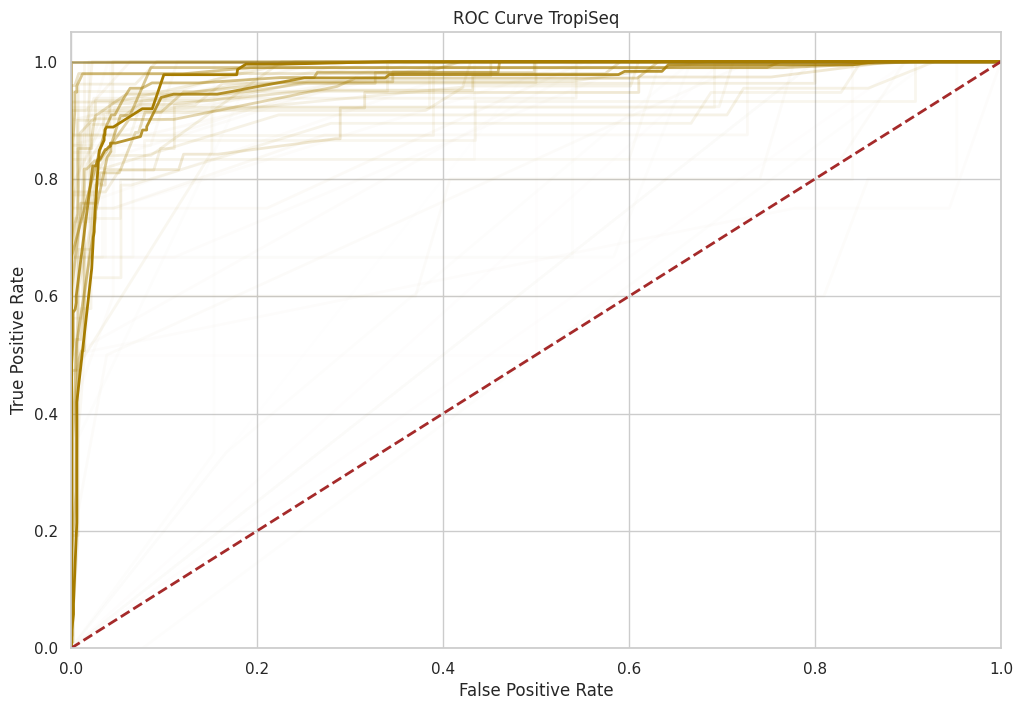

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

def plot_multiple_roc_curves(data_dict, curve_color):
    plt.figure(figsize=(12, 8))
    lw = 2
    sns.set(style="whitegrid")
    for key, value in data_dict.items():
        fpr, tpr, _ = roc_curve(value['y_true'], value['y_pred'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, alpha=value['transparency']/100, color=curve_color, label=f'{key} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='brown', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve TropiSeq')
    #plt.legend(loc="lower right")
    plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/prophage_ROC.TropiSeq.2002.svg', dpi = 500)
    plt.show()

plot_multiple_roc_curves(dico_pred_out, "#a67c00")